In [24]:
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC

In [152]:
#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import unidecode
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

[nltk_data] Downloading package wordnet to /home/wall-e/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/wall-e/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [4]:
dataset = pd.read_csv("./Dataset/X_train.csv", sep=",")
dataset_test = pd.read_csv("./Dataset/X_test.csv", sep=",")

X_train = dataset["Caption"]
categories = dataset[["Id", "category_1", "category_2", "category_3", "category_4"]]

# output corresponding to the category 1 (does the answer belongs to cat 1)
y_train1 = dataset["category_1"]
y_train2 = dataset["category_2"]
y_train3 = dataset["category_3"]
y_train4 = dataset["category_4"]

In [5]:
print(f"Fraction of 1 in category 1: {sum(y_train1) / y_train1.shape[0]}")
print(f"Fraction of 1 in category 2: {sum(y_train2) / y_train2.shape[0]}")
print(f"Fraction of 1 in category 3: {sum(y_train3) / y_train3.shape[0]}")
print(f"Fraction of 1 in category 4: {sum(y_train4) / y_train4.shape[0]}")

Fraction of 1 in category 1: 0.27835051546391754
Fraction of 1 in category 2: 0.354639175257732
Fraction of 1 in category 3: 0.488659793814433
Fraction of 1 in category 4: 0.11752577319587629


/home/wall-e/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


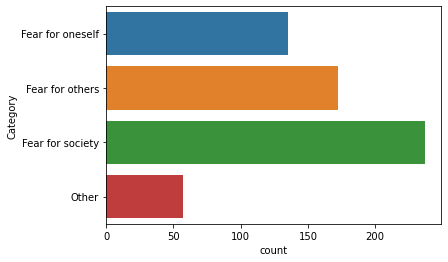

In [6]:
categories.rename(
    columns={
        "category_1": "Fear for oneself",
        "category_2": "Fear for others",
        "category_3": "Fear for society",
        "category_4": "Other"
    },
    inplace=True,
)

df = pd.melt(
    categories,
    id_vars=["Id"],
    value_vars=["Fear for oneself", "Fear for others", "Fear for society", "Other"],
    var_name="Category",
)
df = df[df["value"] == 1]

#g = sns.set_theme(style="darkgrid")
sns.countplot(data=df, y="Category")
plt.show()

In [168]:
def form_sentence(text):
    text = text.replace("&", "e")
    blob = TextBlob(text)
    return ' '.join(blob.words)

print(form_sentence(dataset['Caption'].iloc[10]))
print(dataset['Caption'].iloc[10])

la reprise en plusieurs étapes de la pandémie la crise économique et sociale en particulier chez les plus demunis
la reprise en plusieurs étapes de la pandémie
 la crise économique et sociale, en particulier chez les plus d&munis


In [169]:
def no_user_alpha(text):
    text_list = [ele for ele in text.split() if ele != 'user']
    text_list = [unidecode.unidecode(ele) for ele in text_list]
    clean_tokens = [t for t in text_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('french')]
    return clean_mess
print(no_user_alpha(form_sentence(dataset['Caption'].iloc[10])))
print(dataset['Caption'].iloc[10])

['reprise', 'plusieurs', 'etapes', 'pandemie', 'crise', 'economique', 'sociale', 'particulier', 'chez', 'plus', 'demunis']
la reprise en plusieurs étapes de la pandémie
 la crise économique et sociale, en particulier chez les plus d&munis


In [170]:
def normalization(text_list):
        lem = WordNetLemmatizer()
        normalized_caption = []
        for word in text_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_caption.append(normalized_text)
        return normalized_caption

In [171]:
def text_processing(text):
    return normalization(no_user_alpha(form_sentence(text)))

In [199]:
def predict_for_cat(category):
    msg_train, msg_test, label_train, label_test = train_test_split(dataset['Caption'], dataset[category], test_size=0.001, random_state=0)
    pipeline = Pipeline([
        ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', SVC(C=1.6, kernel='linear',random_state=2)),  # train on TF-IDF vectors w/ SVC
        #('classifier', RandomForestClassifier(n_estimators=1000, random_state=0)),  # train on TF-IDF vectors w/ SVC
    ])
    pipeline.fit(msg_train,label_train)
    predictions = pipeline.predict(msg_test)
    print(classification_report(predictions,label_test))
    print(confusion_matrix(predictions,label_test))
    print(accuracy_score(predictions,label_test))
    return pipeline

In [200]:
msg_test = dataset_test['Caption'].squeeze()
indexes = dataset_test['Id'].squeeze()

In [201]:
model1 = predict_for_cat('category_1')
model2 = predict_for_cat('category_2')
model3 = predict_for_cat('category_3')
model4 = predict_for_cat('category_4')

predict1 = model1.predict(msg_test)
predict2 = model2.predict(msg_test)
predict3 = model3.predict(msg_test)
predict4 = model4.predict(msg_test)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.

In [202]:
with open('submission.csv','w') as f:
    f.write('Id,category_1,category_2,category_3,category_4\n')
    for i in range(len(predict1)):
        f.write(f"{indexes[i]},{predict1[i]},{predict2[i]},{predict3[i]},{predict4[i]}\n")